## Simple linear regession regularization

In [1]:
from abc import ABCMeta
import six
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.base import RegressorMixin
from sklearn.linear_model.base import LinearModel
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# set random seed to have consistent result
np.random.seed(1)

%matplotlib inline

### Helper function

In [2]:
def compute_rmse(target, pred):
    """Compute RMSE between predict and true target
    """
    return np.sqrt(mean_squared_error(target, pred))


def create_poly_feature_pipe(degree, normalize=True):
    """Creaet poly feature transform pipeline
    """
    poly = PolynomialFeatures(degree, include_bias=False)
    
    if normalize:
        scaler = StandardScaler()
        pipe = make_pipeline(poly, scaler)
    else:
        pipe = make_pipeline(poly)
        
    return pipe
        

def extract_model_weights(model):
    """Extract weights from model
    """
    if hasattr(model, 'intercept_'):
        w = np.zeros(len(model.coef_.ravel()) + 1)
        w[0] = model.intercept_
        w[1:] = model.coef_.ravel()
    else:
        w = model.coef_.copy()
        
    return w
    
    
def print_model_weight(model):    
    print('weights:\n', np.array2string(extract_model_weights(model).ravel(), 
                        formatter={'float_kind':'{:2.6e}'.format}, max_line_width=80))

def print_model_rmse(model, preprocess_pipe, data_set, string_format='RMSE: {:2.6e}'):
    X, y  = data_set
    X_tr = preprocess_pipe.transform(X)
    rmse = compute_rmse(y, model.predict(X_tr))
    print(string_format.format(rmse))


def show_model_result(model, preprocess_pipe, train_set, valid_set=None, test_set=None):
    """Print linear regression model RMSE and weights
    
    :param model: linear regression model
    :param preprocess_pipe:  preprocess pipeline 
    :param train_set: (X, y) tuple train data X, y 
    :param valid_set: (X, y) tuple valid data X, y
    :param test_set:  (X, y) tuple test  data X, y
    """
    
    print_model_rmse(model, preprocess_pipe, train_set, 'Train RMSE: {:2.6e}')
    
    if valid_set is not None:
        print_model_rmse(model, preprocess_pipe, valid_set, 'Valid RMSE: {:2.6e}')
    
    if test_set is not None:
        print_model_rmse(model, preprocess_pipe, test_set, 'Test RMSE: {:2.6e}')
    
    print_model_weight(model)
    print('='*80)


def plot_model_result(model, preprocess_pipe, train_set, valid_set=None, test_set=None):
    """Plot linear regression model result
    """
    
    def plot_data(data_set, color, label):
        X, y = data_set
        plt.scatter(X, y, color=color, s=20, alpha=0.5, label=label)
    
    plt.figure(figsize=(5, 5))
        
    plot_data(train_set, color='b', label='Train')

    if valid_set is not None:
        plot_data(valid_set, color='g', label='Valid')
        
    if test_set is not None:
        plot_data(test_set, color='y', label='Test')
    
    train_X, train_y = train_set
    plot_X = np.linspace(train_X.min(), train_X.max(), 1000).reshape([-1, 1])
    plot_X_tr = preprocess_pipe.transform(plot_X)
    plot_y_pred = model.predict(plot_X_tr)
    plt.plot(plot_X, plot_y_pred, label='model', linewidth=3, color='r')
    
    plt.title('lambda: {:.2e}'.format(model.alpha))
    plt.xlim(xmin=train_X.min(), xmax=train_X.max())
    plt.ylim(ymin=train_y.min(), ymax=train_y.max())
    plt.xlabel('X', fontsize='large')
    plt.ylabel('y', rotation='horizontal', fontsize='large')
    plt.legend(loc='upper right')
    plt.show()

### Linear Regression cost and gradient function

In [3]:
def compute_cost(X, y, w, lambda_):
    """Linear regression cost function with l2-norm regularization
    """
    n_samples, n_features = X.shape
    
    y_hat = X @ w
    diff = y_hat - y
    
    ww = w.copy()
    ww[0] = 0
    cost = (diff.T @ diff + lambda_ * ww.T @ ww) / (2 * n_samples) 
    
    return cost

    
def compute_grad(X, y, w, lambda_):
    """Linear regression grad function with l2-nrom regularization
    """
    n_samples, n_features = X.shape
    y_hat = X @ w
    diff = y_hat - y

    # compute grad
    cost_grad = X.T @ diff
        
    # compute regularization grad
    mask = np.ones([n_features, 1])
    mask[0] = 0
    reg_grad = lambda_ * (w * mask) 
    grad = (cost_grad + reg_grad) / n_samples
          
    return grad

### Base Solver

In [4]:
class _BaseSolver(six.with_metaclass(ABCMeta, LinearModel)):
    def predict(self, X, y=None):
        X, y = preprocess_data(X, y, self.add_bias)
        return X @ self.coef_

#    def rmse(self, X, y):
#        return rmse(self.predict(X) - y)
#    
#    def cost(self, X, y):
#        return compute_cost(y, self.predict(X))


def preprocess_data(X, y, add_bias):
    """Preprocess X, y data with add bias term to X
    
    :param X: {n_samples, n_featurs}
    :param y: {n_samples}
    :param add_bias: if True add bias term to X
    :return: X, y
    """
    X = X.copy()
    
    if add_bias:
        bias = np.ones([X.shape[0], 1])
        X = np.hstack([bias, X])
    
    return X, y

### Gradient Descent Solver

In [5]:
def gradient_descent_solver(X, y, lambda_=1, learning_rate=1e-2, tol=1e-8, max_iter=None):
    """Solve Xw = y using gradient desecent method with l2-norm regularization
    
    :param X: {n_samples, n_featurs}
    :param y: {n_samples} 
    :param lambda_: l2-norm regularization penalty
    :param learning_rate: gradent step 
    :param tol: tolerance between cost funciton
    :param max_iter: max iterations number
    :return: {n_samples} coffecient
    """
    n_samples, n_features = X.shape
    w = np.zeros([n_features, 1])
    
    mask = np.ones([n_features, 1])
    mask[0] = 0
    
    if max_iter is None:
        max_iter = 1000
    costs = np.zeros(max_iter)
    
    costs[0] = compute_cost(X, y, w, lambda_)
    for n_iter in np.arange(1, max_iter):    
        y_hat = X @ w
        diff = y_hat - y
    
        grad = compute_grad(X, y, w, lambda_)
        w = w - learning_rate * grad
        
        costs[n_iter] = compute_cost(X, y, w, lambda_)
        
        #print('costs[%4d]: %.8f' % (n_iter, costs[n_iter]))
        if np.abs(costs[n_iter - 1] - costs[n_iter]) < tol:
            costs = costs[:n_iter]
            break
    
    return w, n_iter, costs
    

# from scipy.optimize import fmin_cg
# 
# class CGSolver(_BaseSolver, RegressorMixin):
#     """USing scipy.optimize.fmin_cg to optimize linear regression model
#     """
#     def __init__(self, alpha=1.0, add_bias=True, max_iter=None, tol=1e-6):
#         self.alpha = alpha
#         self.add_bias = add_bias
#         self.max_iter = max_iter
#         self.tol = tol
#         
#     def fit(self, X, y):
#         X, y = preprocess_data(X, y, self.add_bias)
# 
#         def cost_fun(w, X, y, lambda_):
#             w = np.reshape(w, [-1, 1])
#             return compute_cost(X, y, w, lambda_)
#         
#         def grad_fun(w, X, y, lambda_):
#             w = np.reshape(w, [-1, 1])
#             grad = compute_grad(X, y, w, lambda_)
#             
#             return grad.flatten()
#         
#         x0 = np.zeros([X.shape[1]])
#         self.coef_ = \
#             fmin_cg(cost_fun, x0, fprime=grad_fun, args=(X, y, self.alpha), 
#                     maxiter=self.max_iter, epsilon=self.tol,
#                     disp=True)
#         self.coef_ = self.coef_.T
        
    
class GradientDescentSolver(_BaseSolver, RegressorMixin):
    """Gradient descent solver with l2 regularization
    
    This model solves a regression model with the loss function using
    gradient descent method with l2-nrom regularization
    """
    
    def __init__(self, alpha=1.0, add_bias=True, learning_rate=1e-2, max_iter=None, tol=1e-8):
        self.alpha = alpha
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        
    def fit(self, X, y):
        X, y = preprocess_data(X, y, self.add_bias)
        
        self.coef_, self.n_iters_, self.costs_ = \
            gradient_descent_solver(X, y, 
                                    lambda_=self.alpha, learning_rate=self.learning_rate,
                                    max_iter=self.max_iter, tol=self.tol)

## 1.Polynomial regression / overfitting / regularization

### Fit the data using linear (1st order) regression model (gradient descent method)

In [6]:
# Prepare data
df = pd.read_csv('ex2data1.csv')
data1_X = df.iloc[:, :-1].values.reshape([-1, 1])
data1_y = df.iloc[:, -1].values.reshape([-1, 1])

data1_train_set = (data1_X, data1_y)

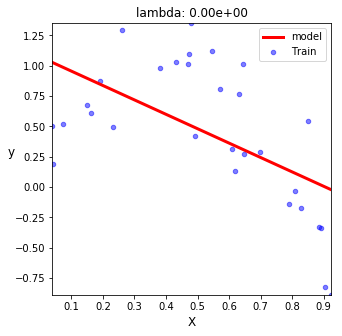

Train RMSE: 4.762412e-01
weights:
 [4.518942e-01 -3.256448e-01]


In [7]:
# parameters
degree = 1
lambda_ = 0

# create preprocess pipe line
preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data1_X_tr = preprocess_pipe.fit_transform(data1_X)
    
model = GradientDescentSolver(lambda_)
model.fit(data1_X_tr, data1_y)

plot_model_result(model, preprocess_pipe, data1_train_set)
show_model_result(model, preprocess_pipe, data1_train_set)

### Fit the data using 2nd order polynomial regression model (gradient descent method).

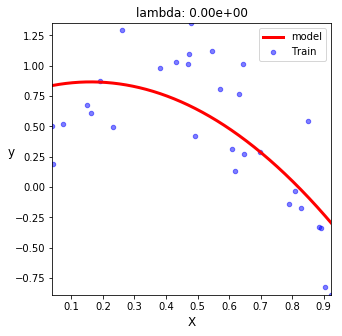

Train RMSE: 3.755797e-01
weights:
 [4.526718e-01 1.775253e-01 -5.525295e-01]


In [8]:
# parameters
degree = 2
lambda_ = 0

# create preprocess pipe line
preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data1_X_tr = preprocess_pipe.fit_transform(data1_X)
    
model = GradientDescentSolver(lambda_)
model.fit(data1_X_tr, data1_y)

plot_model_result(model, preprocess_pipe, data1_train_set)
show_model_result(model, preprocess_pipe, data1_train_set)

### Fit the data using 4th order polynomial regression model (gradient descent method).

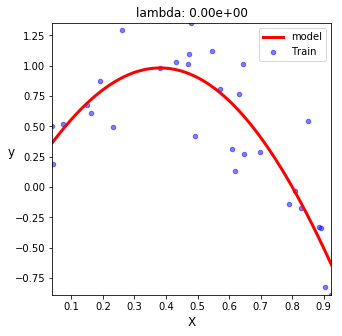

Train RMSE: 2.859446e-01
weights:
 [4.526915e-01 1.030905e+00 -1.067298e+00 -6.427149e-01 3.041556e-01]


In [9]:
# parameters
degree = 4
lambda_ = 0

# create preprocess pipe line
preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data1_X_tr = preprocess_pipe.fit_transform(data1_X)
    
model = GradientDescentSolver(lambda_, learning_rate=0.1, max_iter=8000)
model.fit(data1_X_tr, data1_y)

plot_model_result(model, preprocess_pipe, data1_train_set)
show_model_result(model, preprocess_pipe, data1_train_set)

### Fit the data using 16th order polynomial regression model (gradient descent method).

With 16 degree poly features, but only have very small sample data (aka a under-fitting system)

This caused matrix ***X*** very ill-conditioned.

Without L2-norm regularization (lambda_ = 0), matrix form result is very unstable

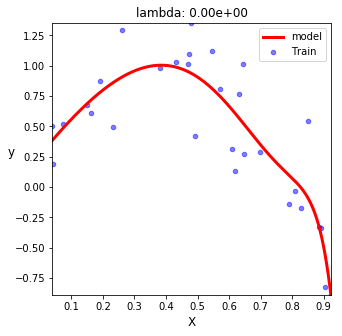

Train RMSE: 2.669959e-01
weights:
 [4.526915e-01 8.726567e-01 -5.016180e-01 -7.156187e-01 -5.112561e-01
 -2.209791e-01 3.184160e-02 2.099516e-01 3.098630e-01 3.403778e-01 3.137582e-01
 2.421718e-01 1.363897e-01 5.450393e-03 -1.432773e-01 -3.038873e-01
 -4.716956e-01]


In [10]:
# parameters
degree = 16
lambda_ = 0

# create preprocess pipe line
preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data1_X_tr = preprocess_pipe.fit_transform(data1_X)
    
model = GradientDescentSolver(lambda_, learning_rate=0.1, max_iter=2000)
model.fit(data1_X_tr, data1_y)

plot_model_result(model, preprocess_pipe, data1_train_set)
show_model_result(model, preprocess_pipe, data1_train_set)

### Fit the data using 16th order polynomial regression model with ridge (L2 penalty) regularization (gradient descent method).

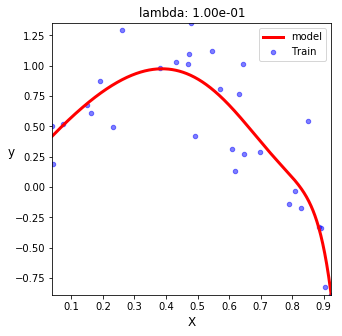

Train RMSE: 2.706117e-01
weights:
 [4.526915e-01 7.686523e-01 -4.245957e-01 -6.240122e-01 -4.564236e-01
 -2.090205e-01 9.563386e-03 1.655288e-01 2.548434e-01 2.845109e-01 2.647890e-01
 2.060172e-01 1.174294e-01 6.823950e-03 -1.194076e-01 -2.561172e-01
 -3.992032e-01]


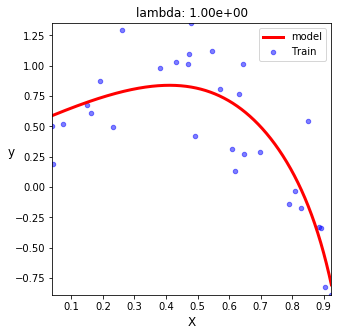

Train RMSE: 3.018666e-01
weights:
 [4.526915e-01 3.019992e-01 -1.146583e-01 -2.124183e-01 -1.876443e-01
 -1.288632e-01 -7.024094e-02 -2.350252e-02 8.651749e-03 2.702378e-02
 3.360598e-02 3.061492e-02 2.010775e-02 3.854443e-03 -1.667958e-02
 -4.030677e-02 -6.607679e-02]


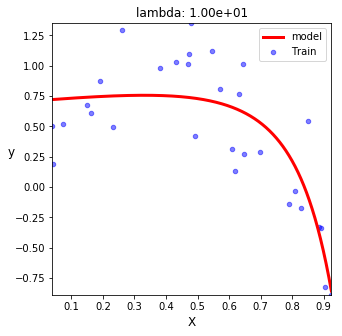

Train RMSE: 3.267718e-01
weights:
 [4.526899e-01 5.506156e-02 -2.686877e-02 -5.609272e-02 -6.145745e-02
 -5.748909e-02 -5.053889e-02 -4.328606e-02 -3.679048e-02 -3.139504e-02
 -2.713025e-02 -2.389932e-02 -2.156293e-02 -1.997717e-02 -1.900932e-02
 -1.854316e-02 -1.847962e-02]


In [11]:
# parameters
degree = 16

# create preprocess pipe line
preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data1_X_tr = preprocess_pipe.fit_transform(data1_X)
    
lambda_vec = [np.power(10.0, p) for p in np.arange(-1, 2, 1)]

for lambda_ in lambda_vec:

    model = GradientDescentSolver(lambda_, learning_rate=0.1, max_iter=3000)
    model.fit(data1_X_tr, data1_y)

    plot_model_result(model, preprocess_pipe, data1_train_set)
    show_model_result(model, preprocess_pipe, data1_train_set)

### Fit the data using 16th order polynomial regression model with scikit-learn Ridge model.

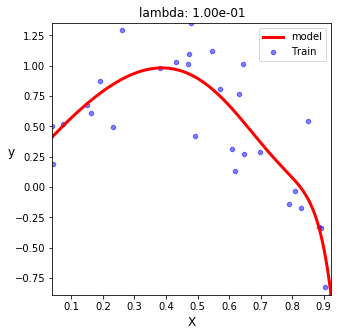

Train RMSE: 2.693815e-01
weights:
 [4.526915e-01 7.848569e-01 -4.198048e-01 -6.474652e-01 -4.847569e-01
 -2.270806e-01 6.461832e-03 1.760727e-01 2.750351e-01 3.095131e-01 2.898680e-01
 2.269953e-01 1.308752e-01 1.010497e-02 -1.281454e-01 -2.780067e-01
 -4.347306e-01]


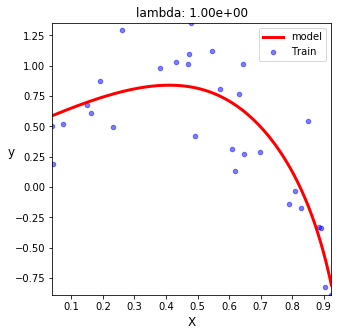

Train RMSE: 3.015547e-01
weights:
 [4.526915e-01 3.053271e-01 -1.171447e-01 -2.155553e-01 -1.895966e-01
 -1.293182e-01 -6.945018e-02 -2.187918e-02 1.069068e-02 2.911397e-02
 3.545038e-02 3.198174e-02 2.082246e-02 3.790409e-03 -1.760999e-02
 -4.215991e-02 -6.888419e-02]


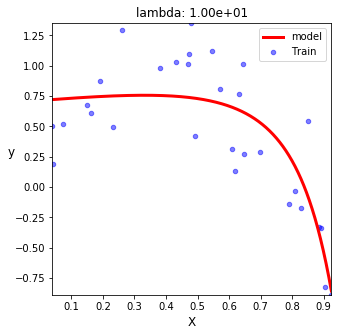

Train RMSE: 3.267045e-01
weights:
 [4.526915e-01 5.560105e-02 -2.707079e-02 -5.644170e-02 -6.173571e-02
 -5.764355e-02 -5.057775e-02 -4.323712e-02 -3.668487e-02 -3.126116e-02
 -2.699188e-02 -2.377544e-02 -2.146823e-02 -1.992273e-02 -1.900323e-02
 -1.859114e-02 -1.858551e-02]


In [12]:
from sklearn.linear_model import Ridge

# parameters
degree = 16

# create preprocess pipe line
preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data1_X_tr = preprocess_pipe.fit_transform(data1_X)

lambda_vec = [np.power(10.0, p) for p in np.arange(-1, 2, 1)]

for lambda_ in lambda_vec:

    model = Ridge(lambda_)
    model.fit(data1_X_tr, data1_y)

    plot_model_result(model, preprocess_pipe, data1_train_set)
    show_model_result(model, preprocess_pipe, data1_train_set)

### Fit the data using 16th order polynomial regression model with scikit-learn Lasso model.

L1-norm regularization tend to sparse solution, so the most weights compressed

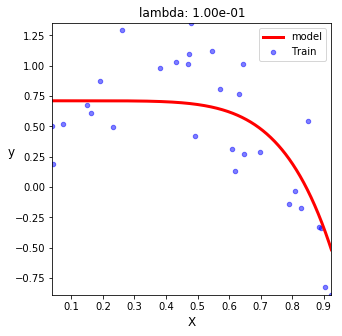

Train RMSE: 3.446671e-01
weights:
 [4.526915e-01 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
 -0.000000e+00 -3.737387e-01 -0.000000e+00 -0.000000e+00 -0.000000e+00
 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
 -0.000000e+00 -0.000000e+00]


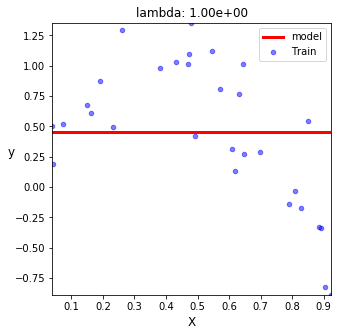

Train RMSE: 5.772554e-01
weights:
 [4.526915e-01 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
 -0.000000e+00 -0.000000e+00]


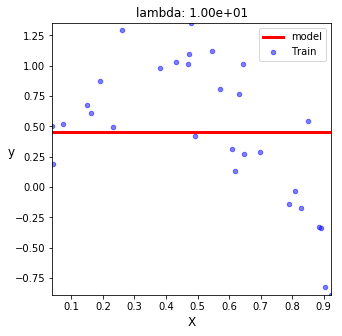

Train RMSE: 5.772554e-01
weights:
 [4.526915e-01 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
 -0.000000e+00 -0.000000e+00]


In [13]:
from sklearn.linear_model import Lasso

# create preprocess pipe line
preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data1_X_tr = preprocess_pipe.fit_transform(data1_X)

# parameters
degree = 16

lambda_vec = [np.power(10.0, p) for p in np.arange(-1, 2, 1)]

for lambda_ in lambda_vec:

    model = Lasso(lambda_)
    model.fit(data1_X_tr, data1_y)

    plot_model_result(model, preprocess_pipe, data1_train_set)
    show_model_result(model, preprocess_pipe, data1_train_set)

## 2.Polynomial regression with train/validation/test

In [14]:
def train_val_test_split(data, train_ratio, valid_ratio, test_ratio):
    """Split with ratio
    """
    shuffle_idx = np.random.permutation(len(data))
    
    train_size = int(len(data) * train_ratio)
    valid_size = int(len(data) * valid_ratio)
    test_size  = int(len(data) * test_ratio)
    
    train_idx = shuffle_idx[:train_size]
    valid_idx = shuffle_idx[(train_size):(train_size + valid_size)]
    test_idx  = shuffle_idx[(train_size + valid_size):]

    return data.iloc[train_idx], data.iloc[valid_idx], data.iloc[test_idx]

In [15]:
df = pd.read_csv('ex2data2.csv')
split_train, split_valid, split_test = train_val_test_split(df, 0.6, 0.2, 0.2)

data2_train_X, data2_train_y = split_train.iloc[:, 0].values.reshape(-1, 1), \
                               split_train.iloc[:, -1].values.reshape(-1, 1)
data2_valid_X, data2_valid_y = split_valid.iloc[:, 0].values.reshape(-1, 1), \
                               split_valid.iloc[:, -1].values.reshape(-1, 1)
data2_test_X ,  data2_test_y = split_test.iloc[:, 0].values.reshape(-1, 1), \
                               split_test.iloc[:, -1].values.reshape(-1, 1)

data2_train_set = (data2_train_X, data2_train_y)
data2_valid_set = (data2_valid_X, data2_valid_y)
data2_test_set  = (data2_test_X ,  data2_test_y)

### Fit the data using linear (1st order) regression model

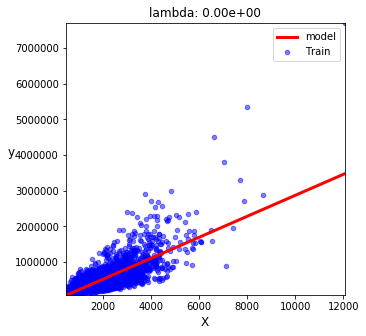

Train RMSE: 2.639939e+05
Test RMSE: 2.760389e+05
weights:
 [5.389715e+05 2.803173e+05]


In [16]:
# parameters
degree = 1
lambda_ = 0

# create preprocess pipe line
preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data2_train_X_tr = preprocess_pipe.fit_transform(data2_train_X)
    
model = GradientDescentSolver(lambda_)
model.fit(data2_train_X_tr, data2_train_y)

plot_model_result(model, preprocess_pipe, data2_train_set)
show_model_result(model, preprocess_pipe, data2_train_set, test_set=data2_test_set)

### Fit the data using 2nd order polynomial regression model

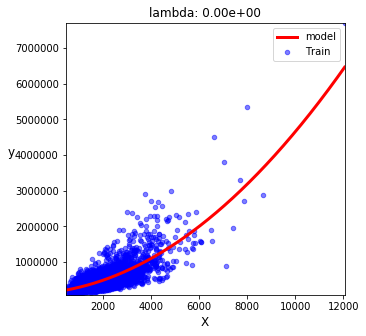

Train RMSE: 2.439359e+05
Test RMSE: 2.439359e+05
weights:
 [5.389715e+05 8.558518e+04 2.150161e+05]


In [17]:
# parameters
degree = 2
lambda_ = 0

# create preprocess pipe line
preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data2_train_X_tr = preprocess_pipe.fit_transform(data2_train_X)
    
model = GradientDescentSolver(lambda_)
model.fit(data2_train_X_tr, data2_train_y)

plot_model_result(model, preprocess_pipe, data2_train_set)
show_model_result(model, preprocess_pipe, data2_train_set, test_set=data2_train_set)

### Fit the data using 4th order polynomial regression model

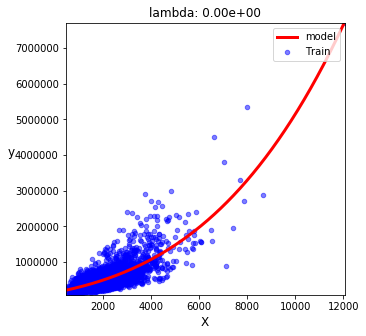

Train RMSE: 2.431381e+05
Test RMSE: 2.703825e+05
weights:
 [5.389715e+05 1.204871e+05 1.174638e+05 6.489400e+04 1.282818e+04]


In [18]:
# parameters
degree = 4
lambda_ = 0

# create preprocess pipe line
preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data2_train_X_tr = preprocess_pipe.fit_transform(data2_train_X)
    
model = GradientDescentSolver(lambda_)
model.fit(data2_train_X_tr, data2_train_y)

plot_model_result(model, preprocess_pipe, data2_train_set)
show_model_result(model, preprocess_pipe, data2_train_set, test_set=data2_test_set)

### Fit the data using 16th order polynomial regression model

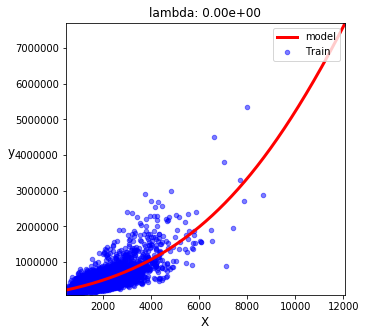

Train RMSE: 2.431608e+05
Test RMSE: 2.706542e+05
weights:
 [5.389715e+05 1.193932e+05 1.139990e+05 6.602277e+04 2.264566e+04 3.129425e+03
 -2.785790e+03 -3.673989e+03 -3.086019e+03 -2.215204e+03 -1.409348e+03
 -7.447167e+02 -2.184741e+02 1.910681e+02 5.069261e+02 7.490486e+02
 9.337175e+02]


In [19]:
# parameters
degree = 16
lambda_ = 0

# create preprocess pipe line
preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data2_train_X_tr = preprocess_pipe.fit_transform(data2_train_X)
    
model = GradientDescentSolver(lambda_)
model.fit(data2_train_X_tr, data2_train_y)

plot_model_result(model, preprocess_pipe, data2_train_set)
show_model_result(model, preprocess_pipe, data2_train_set, test_set=data2_test_set)

### Fit the data using 16th order polynomial regression model with ridge

#### To select optimal $\lambda$ by compute different rmse for test and valid

In [20]:
def compute_validate_curve(model, preprocess_pipe, 
                           train_set, valid_set, lambda_vec):
    """Compute different lambda_ value affect RMSE for train and valid set
    """
    train_rmse = np.zeros(len(lambda_vec))
    valid_rmse = np.zeros(len(lambda_vec))
    weights = []
    
    train_X, train_y = train_set
    valid_X, valid_y = valid_set
    
    train_X_tr = preprocess_pipe.transform(train_X)
    valid_X_tr = preprocess_pipe.transform(valid_X)
    
    for idx, lambda_ in enumerate(lambda_vec):
        
        # dirty hack to chage model regularization penalty
        model.alpha = lambda_
        model.fit(train_X_tr, train_y)
        weights.append(extract_model_weights(model))
        
        train_rmse[idx] = compute_rmse(train_y, model.predict(train_X_tr))
        valid_rmse[idx] = compute_rmse(valid_y, model.predict(valid_X_tr))
    
    weights = np.squeeze(np.array(weights))
    
    return train_rmse, valid_rmse, weights

def plot_validate_curve(train_rmse, valid_rmse, lambda_vec):
    """Plot different lambda on train and valid result
    """
    plt.figure(figsize=(8, 5))
    plt.plot(lambda_vec, train_rmse, color='g', alpha=0.5, label='Train')
    plt.plot(lambda_vec, valid_rmse, color='b', alpha=0.5, label='Valid')
    plt.title('$\lambda$ curve')
    plt.xlim(xmin=lambda_vec.min(), xmax=lambda_vec.max())
    plt.ylim(ymax=max(train_rmse.max(), valid_rmse.max()))
    plt.xlabel('$\lambda$', fontsize='large')
    plt.ylabel('RMSE', fontsize='large')
    plt.legend(loc='upper right')
    plt.show()
    
    
def plot_lambda_weights_effect(weights, lambda_vec, weights_name):
    """Plot the weights value change with different lambda
    
    :param weights: [n_lambda, n_feature] 
    :param lambda_vec: [n_lambda] 
    :param weights_name: list of weight name with length n_lambda
    """
    
    plt.figure(figsize=(8, 5))
    n_lambda, n_features = weights.shape
    
    for n in range(n_features):
        w = weights[:, n]
        label_name = weights_name[n]
        plt.plot(lambda_vec, w, label=label_name, alpha=0.7)

    plt.title('weights regularization by lambda')
    plt.xlabel('$\lambda$')
    plt.ylabel('weight')

    plt.legend(loc="upper right")

#### Gradient Descent

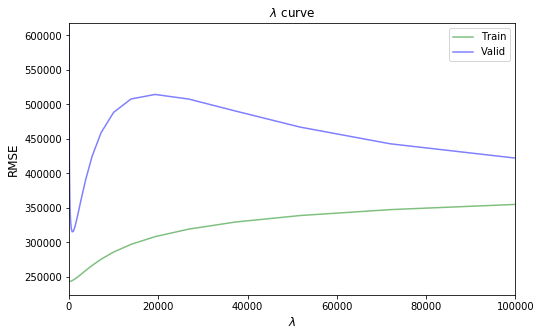

In [21]:
# parameters
degree = 16

grid = np.linspace(-2, 5, 50)
lambda_vec = np.array([0] + [np.power(10.0, p) for p in grid])
#lambda_vec = np.r_[0, np.logspace(-2, 5, 20)].reshape(-1, 1)

train_rmse = np.zeros(len(lambda_vec))
valid_rmse = np.zeros(len(lambda_vec))

# FIXME: GradientDescentSolver get wrong result in compute_validate_curve
#preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
#preprocess_pipe.fit(X_train)
#model = GradientDescentSolver(learning_rate=0.01, max_iter=8000)
#train_rmse, valid_rmse = compute_validate_curve(model, preprocess_pipe, train_set, valid_set, lambdas)
#plot_validate_curve(train_rmse, valid_rmse, lambdas)

# create preprocess pipe line
preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data2_train_X_tr = preprocess_pipe.fit_transform(data2_train_X)
data2_valid_X_tr = preprocess_pipe.transform(data2_valid_X)

weights = []
for idx, lambda_ in enumerate(lambda_vec):

    model = GradientDescentSolver(lambda_, learning_rate=0.01, max_iter=8000)
    model.fit(data2_train_X_tr, data2_train_y)
    weights.append(extract_model_weights(model))
    
    train_rmse[idx] = compute_rmse(data2_train_y, model.predict(data2_train_X_tr))
    valid_rmse[idx] = compute_rmse(data2_valid_y, model.predict(data2_valid_X_tr))

weights = np.squeeze(np.array(weights))

plot_validate_curve(train_rmse, valid_rmse, lambda_vec)

#### Gradient Descent with ridge (L2 penalty) regularization $\lambda$ on weights effect

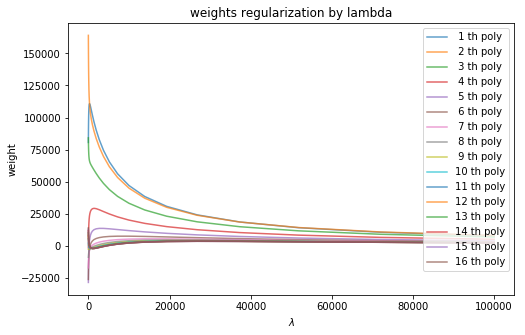

In [22]:
# plot weights with lambda regularization
weights_name = ['{:2d} th poly'.format(d) for d in np.arange(1, degree + 1)]
weights = weights[:, 1:] # remove bias term
plot_lambda_weights_effect(weights, lambda_vec, weights_name)

#### Gradient Decent best $\lambda$ result

optimal lambda 1.000000e+05


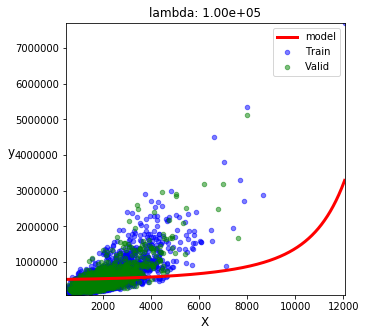

Train RMSE: 3.549563e+05
Valid RMSE: 4.221007e+05
Test RMSE: 3.843122e+05
weights:
 [5.389949e+05 8.084309e+03 8.319990e+03 7.085367e+03 5.340720e+03 4.132110e+03
 3.451596e+03 3.075203e+03 2.860067e+03 2.732314e+03 2.653995e+03 2.604798e+03
 2.573326e+03 2.552911e+03 2.539525e+03 2.530672e+03 2.524774e+03]


In [23]:
# find lambda with lowest train and valid rmse, skip lambda = 0
opt_lambda = lambda_vec[np.argmin(np.abs(train_rmse[1:] - valid_rmse[1:])) + 1]
data2_train_X_tr = preprocess_pipe.transform(data2_train_X)
model.alpha = opt_lambda
model.fit(data2_train_X_tr, data2_train_y)

print("optimal lambda {:2.6e}".format(opt_lambda))
plot_model_result(model, preprocess_pipe, data2_train_set, data2_valid_set)
show_model_result(model, preprocess_pipe, data2_train_set, data2_valid_set, data2_test_set)

### Fit the data using 16th order polynomial regression model with scikit-learn Ridge model.

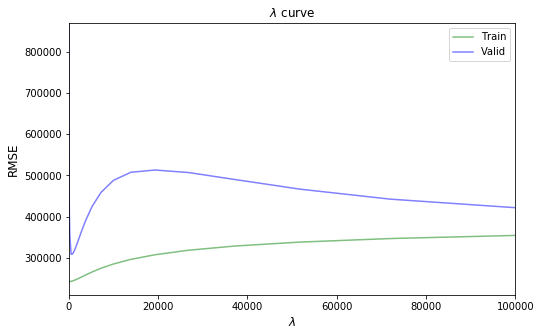

In [24]:
# parameters
degree = 16

grid = np.linspace(-2, 5, 50)
lambda_vec = np.array([0] + [np.power(10.0, p) for p in grid])
#lambda_vec = np.r_[0, np.logspace(-2, 5, 20)].reshape(-1, 1)

preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
preprocess_pipe.fit(data2_train_X)

model = Ridge(solver='lsqr')
train_rmse, valid_rmse, weights = compute_validate_curve(model, preprocess_pipe, 
                                                data2_train_set, data2_valid_set, lambda_vec)
plot_validate_curve(train_rmse, valid_rmse, lambda_vec)

#### scikit-learn Ridge $\lambda$ on weights effect

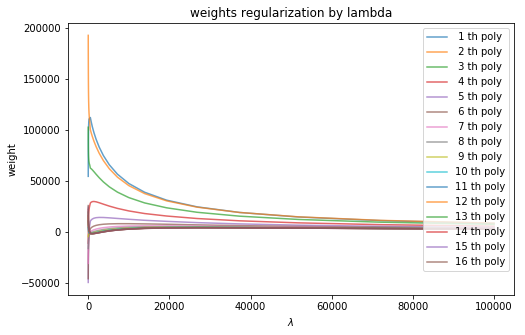

In [25]:
# plot weights with lambda regularization
weights_name = ['{:2d} th poly'.format(d) for d in np.arange(1, degree + 1)]
weights = weights[:, 1:] # remove bias term
plot_lambda_weights_effect(weights, lambda_vec, weights_name)

optimal lambda 7.196857e+02


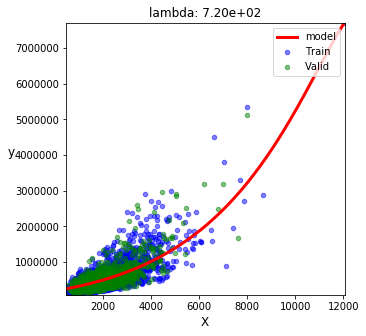

Train RMSE: 2.445460e+05
Valid RMSE: 3.092129e+05
Test RMSE: 2.728780e+05
weights:
 [5.389950e+05 1.078272e+05 9.704428e+04 6.169567e+04 2.882890e+04 1.137930e+04
 3.745701e+03 5.004084e+02 -9.109336e+02 -1.540612e+03 -1.821934e+03
 -1.941313e+03 -1.983602e+03 -1.989463e+03 -1.979083e+03 -1.962611e+03
 -1.945064e+03]


In [26]:
# find lambda with lowest train and valid rmse, skip lambda = 0
opt_lambda = lambda_vec[np.argmin(np.abs(train_rmse[1:] - valid_rmse[1:])) + 1]
data2_train_X_tr = preprocess_pipe.transform(data2_train_X)
model.alpha = opt_lambda
model.fit(data2_train_X_tr, data2_train_y)

print("optimal lambda {:2.6e}".format(opt_lambda))
plot_model_result(model, preprocess_pipe, data2_train_set, data2_valid_set)
show_model_result(model, preprocess_pipe, data2_train_set, data2_valid_set, data2_test_set)

### Fit the data using 16th order polynomial regression model with scikit-learn Lasso model.

/Users/tsungmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/tsungmin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/tsungmin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


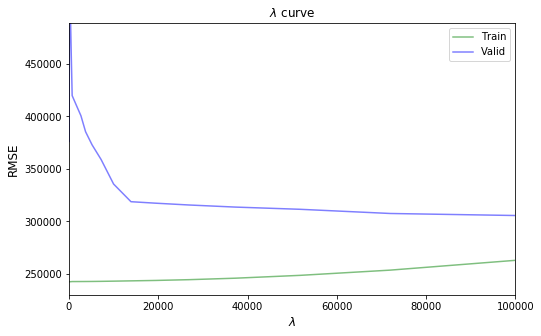

In [27]:
# parameters
degree = 16

grid = np.linspace(-2, 5, 50)
lambda_vec = np.array([0] + [np.power(10.0, p) for p in grid])
#lambda_vec = np.r_[0, np.logspace(-2, 5, 20)].reshape(-1, 1)

preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
preprocess_pipe.fit(data2_train_X)

model = Lasso()
train_rmse, valid_rmse, weights = compute_validate_curve(model, preprocess_pipe, 
                                                data2_train_set, data2_valid_set, lambda_vec)
plot_validate_curve(train_rmse, valid_rmse, lambda_vec)

#### scikit-learn Lasso $\lambda$ on weights effect

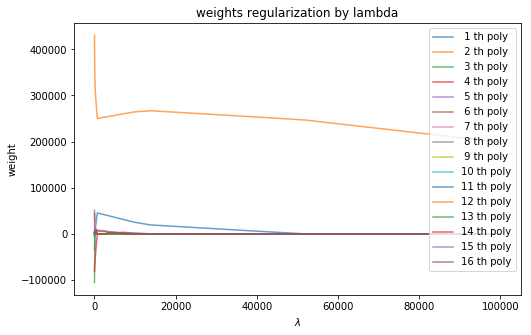

In [28]:
# plot weights with lambda regularization
weights_name = ['{:2d} th poly'.format(d) for d in np.arange(1, degree + 1)]
weights = weights[:, 1:] # remove bias term
plot_lambda_weights_effect(weights, lambda_vec, weights_name)

optimal lambda 1.000000e+05


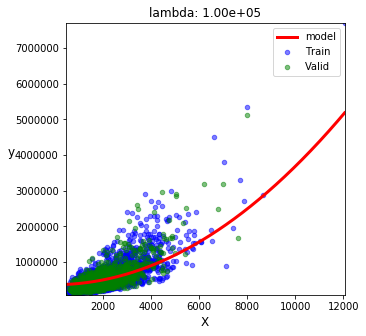

Train RMSE: 2.628424e+05
Valid RMSE: 3.055281e+05
Test RMSE: 2.877116e+05
weights:
 [5.389950e+05 0.000000e+00 1.986492e+05 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]


In [29]:
# find lambda with lowest train and valid rmse, skip lambda = 0
opt_lambda = lambda_vec[np.argmin(np.abs(train_rmse[1:] - valid_rmse[1:])) + 1]
data2_train_X_tr = preprocess_pipe.transform(data2_train_X)
model.alpha = opt_lambda
model.fit(data2_train_X_tr, data2_train_y)

print("optimal lambda {:2.6e}".format(opt_lambda))
plot_model_result(model, preprocess_pipe, data2_train_set, data2_valid_set)
show_model_result(model, preprocess_pipe, data2_train_set, data2_valid_set, data2_test_set)

## 3. Regularization with Tensorflow


In [30]:
df = pd.read_csv('ex2data3.csv')
df = df.drop('Unnamed: 0', axis=1)

split_train, split_valid, split_test = train_val_test_split(df, 0.6, 0.2, 0.2)

data3_train_X, data3_train_y = split_train.iloc[:, 0:-1].values.reshape(-1, 8), \
                               split_train.iloc[:, -1].values.reshape(-1, 1) 
data3_valid_X, data3_valid_y = split_valid.iloc[:, 0:-1].values.reshape(-1, 8), \
                               split_valid.iloc[:, -1].values.reshape(-1, 1)
data3_test_X ,  data3_test_y = split_test.iloc[:, 0:-1].values.reshape(-1, 8), \
                               split_test.iloc[:, -1].values.reshape(-1, 1)

data3_train_set = (data3_train_X, data3_train_y)
data3_valid_set = (data3_valid_X, data3_valid_y)
data3_test_set  = (data3_test_X, data3_test_y)


### Fit the training data using regression model with ridge (L2 penalty) regularization with scikit-learn Ridge model.

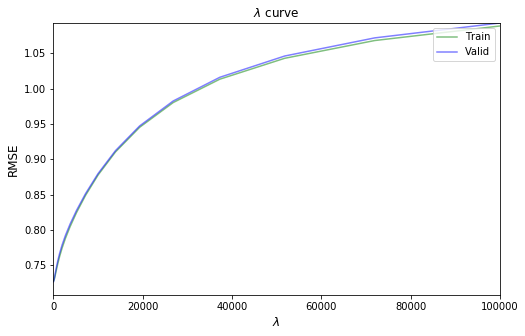

In [31]:
# parameters
degree = 1

grid = np.linspace(-2, 5, 50)
lambda_vec = np.array([0] + [np.power(10.0, p) for p in grid])
#lambda_vec = np.r_[0, np.logspace(-2, 5, 20)].reshape(-1, 1)

preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
preprocess_pipe.fit(data3_train_X)

model = Ridge()
train_rmse, valid_rmse, weights = compute_validate_curve(model, preprocess_pipe, 
                                                data3_train_set, data3_valid_set, lambda_vec)
plot_validate_curve(train_rmse, valid_rmse, lambda_vec)

#### scikit-learn Ridge $\lambda$ on weights effect

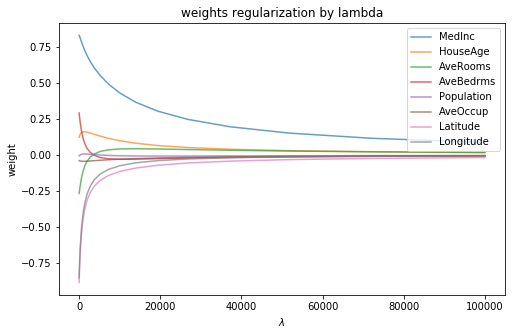

In [32]:
# plot weights with lambda regularization
weights_name = df.columns.values[0:-1]
weights = weights[:, 1:] # remove bias term
plot_lambda_weights_effect(weights, lambda_vec, weights_name)

In [33]:
# find lambda with lowest train and valid rmse, skip lambda = 0
opt_lambda = lambda_vec[np.argmin(np.abs(train_rmse[1:] - valid_rmse[1:])) + 1]
data3_train_X_tr = preprocess_pipe.transform(data3_train_X)
model.alpha = opt_lambda
model.fit(data3_train_X_tr, data3_train_y)

print("optimal lambda {:2.6e}".format(opt_lambda))
show_model_result(model, preprocess_pipe, data3_train_set, data3_valid_set, data3_test_set)

optimal lambda 7.196857e+01
Train RMSE: 7.280416e-01
Valid RMSE: 7.279367e-01
Test RMSE: 7.194024e-01
weights:
 [2.063538e+00 8.243664e-01 1.287287e-01 -2.535765e-01 2.715599e-01
 -5.261773e-03 -4.090744e-02 -8.170355e-01 -7.833527e-01]


### Fit the training data using regression model with lasso (L1 penalty) regularization with scikit-learn Lasso model.

/Users/tsungmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/tsungmin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/tsungmin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


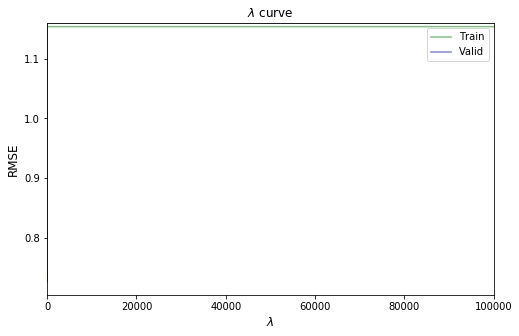

In [34]:
# parameters
degree = 1

grid = np.linspace(-2, 5, 50)
lambda_vec = np.array([0] + [np.power(10.0, p) for p in grid])
#lambda_vec = np.r_[0, np.logspace(-2, 5, 20)].reshape(-1, 1)

preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
preprocess_pipe.fit(data3_train_X)

model = Lasso()
train_rmse, valid_rmse, weights = compute_validate_curve(model, preprocess_pipe, 
                                                data3_train_set, data3_valid_set, lambda_vec)
plot_validate_curve(train_rmse, valid_rmse, lambda_vec)

Lasso train and valid set error is very small, its difficult to viuslaize the difference on graph

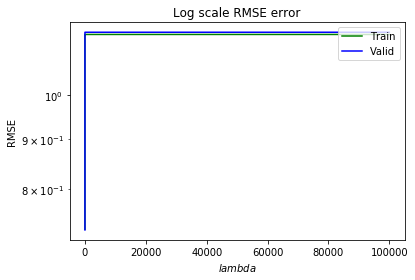

In [35]:
plt.figure()
plt.title('Log scale RMSE error')
plt.semilogy(lambda_vec, train_rmse, color='g', label='Train')
plt.semilogy(lambda_vec, valid_rmse, color='b', label='Valid')
plt.xlabel('$lambda$')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.show()

#### scikit-learn Lasso $\lambda$ on weights effect

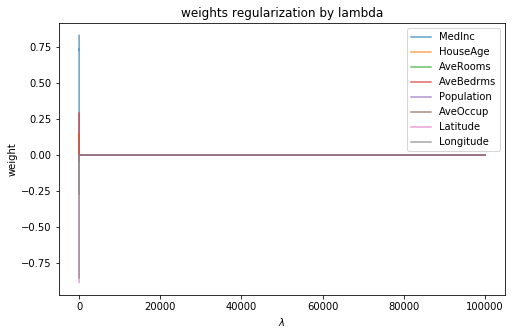

In [36]:
# plot weights with lambda regularization
weights_name = df.columns.values[0:-1]
weights = weights[:, 1:] # remove bias term
plot_lambda_weights_effect(weights, lambda_vec, weights_name)

In [37]:
# find lambda has lowest difference between train and valid rmse
opt_lambda = lambda_vec[np.argmin(np.abs(train_rmse[1:] - valid_rmse[1:])) + 1]
data3_train_X_tr = preprocess_pipe.transform(data3_train_X)
model.alpha = opt_lambda
model.fit(data3_train_X_tr, data3_train_y)

print("optimal lambda {:2.6e}".format(opt_lambda))
show_model_result(model, preprocess_pipe, data3_train_set, data3_valid_set, data3_test_set)

optimal lambda 5.179475e-01
Train RMSE: 9.870982e-01
Valid RMSE: 9.878280e-01
Test RMSE: 9.806112e-01
weights:
 [2.063538e+00 2.725388e-01 0.000000e+00 0.000000e+00 -0.000000e+00
 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00]


### Fit the training data using regression model with ridge (L2 penalty) regularization using TensorFlow.

In [38]:
import tensorflow as tf

/Users/tsungmin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [39]:
class TFGradientDescentSolver(_BaseSolver, RegressorMixin):
    def __init__(self, alpha=1.0, add_bias=True,
                 learning_rate=1e-2, max_iter=None, tol=1e-8, regularizer='Ridge'):
        self.alpha = alpha
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.regularizer = regularizer
        
    def fit(self, X, y, sess):
        X, y = preprocess_data(X, y, self.add_bias)
        
        self.coef_, self.n_iter_, self.costs_ = \
            tf_gradient_descent(sess, X, y, 
                                lambda_=self.alpha, learning_rate=self.learning_rate,
                                tol=self.tol, max_iter=self.max_iter, regularizer=self.regularizer)
        

def tf_gradient_descent(sess, X, y, lambda_=1, learning_rate=1e-2, tol=1e-8, max_iter=None, regularizer='Ridge'):
    n_samples, n_features = X.shape
    
    if max_iter is None:
        max_iter = 1000
    
    mask = np.ones([n_features, 1])
    mask[0] = 0
    costs = np.zeros(max_iter)
    
    # TF variables
    X_ = tf.placeholder(tf.float32, [None, n_features])
    y_ = tf.placeholder(tf.float32, [None, 1])
    learning_rate_ = tf.constant(learning_rate)
    reg_lambda_ = tf.constant(lambda_, dtype=tf.float32)
    mask_ = tf.constant(mask, dtype=tf.float32)
    w_ = tf.Variable(tf.zeros([n_features, 1]))
    
    # cost function term
    diff_ = tf.matmul(X_, w_) - y
    obj_cost_ = tf.reduce_mean(tf.pow(diff_, 2)) / 2
    obj_grad_ = tf.matmul(tf.transpose(X_), diff_) / tf.cast(tf.shape(X_)[0], tf.float32)
    
    # regularization term
    if regularizer == "Ridge":
        reg_cost_ = tf.reduce_sum(tf.pow(mask_ * w_, 2)) / (2 * tf.cast(tf.shape(X_)[0], tf.float32))
        reg_grad_ = (mask_ * w_) / tf.cast(tf.shape(X_)[0], tf.float32)
        cost_ = obj_cost_ + reg_lambda_ * reg_cost_
        grad_ = obj_grad_ + reg_lambda_ * reg_grad_
        
    elif regularizer == "Lasso":
        # FIXME: Lasso soft_threshold implementation is wrong
        #        Using tf.gradient to replace compute l1 gradient
        reg_cost_ = tf.reduce_sum(tf.abs(mask_ * w_)) / (2 * tf.cast(tf.shape(X_)[0], tf.float32))
        #reg_grad_ = w_ / (2 * tf.cast(tf.shape(X_)[0], tf.float32))
        cost_ = obj_cost_ + reg_lambda_ * reg_cost_
        #grad_ = obj_grad_ + reg_lambda_ * reg_grad_
        grad_ = tf.gradients(cost_, xs=w_)
        
    # gradient update step
    train_op = tf.assign(w_, tf.reshape(w_ - learning_rate_ * grad_, [n_features, 1]))
    
    feed_dict = {X_: X, y_: y}
    
    sess.run(tf.assign(w_, tf.zeros([n_features, 1])))
    costs[0] = sess.run(cost_, feed_dict)
    for n_iter in np.arange(1, max_iter):
        _ = sess.run(train_op, feed_dict)
        costs[n_iter] = sess.run(cost_, feed_dict)
        
        #if n_iter % 50 == 0:
        #    costs[n_iter] = sess.run(cost_, feed_dict)
        #    print('costs[%4d]: %.8f' % (n_iter, costs[n_iter]))
        if np.abs(costs[n_iter - 1] - costs[n_iter]) < tol:
            costs = costs[:n_iter]
            break
    w = sess.run(w_)

    return w, n_iter, costs
    

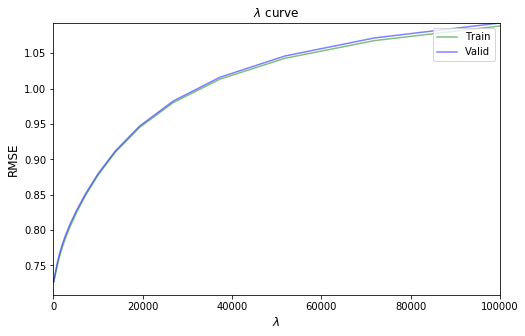

In [40]:
degree = 1

grid = np.linspace(-2, 5, 50)
lambda_vec = np.array([0] + [np.power(10.0, p) for p in grid])
#lambda_vec = np.r_[0, np.logspace(-2, 5, 20)].reshape(-1, 1)

train_rmse = np.zeros(len(lambda_vec))
valid_rmse = np.zeros(len(lambda_vec))

preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data3_train_X_tr = preprocess_pipe.fit_transform(data3_train_X)
data3_valid_X_tr = preprocess_pipe.transform(data3_valid_X)

with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
        
    weights = []
    for idx, lambda_ in enumerate(lambda_vec):

        model = TFGradientDescentSolver(lambda_, learning_rate=0.1, max_iter=2000)
        model.fit(data3_train_X_tr, data3_train_y, sess)
        weights.append(extract_model_weights(model))
        
        train_rmse[idx] = compute_rmse(data3_train_y, model.predict(data3_train_X_tr))
        valid_rmse[idx] = compute_rmse(data3_valid_y, model.predict(data3_valid_X_tr))
    
weights = np.squeeze(np.array(weights))
    
plot_validate_curve(train_rmse, valid_rmse, lambda_vec)

#### TensorFlow Gradient Descent with ridge (L2 penalty) regularization $\lambda$ on weights effect

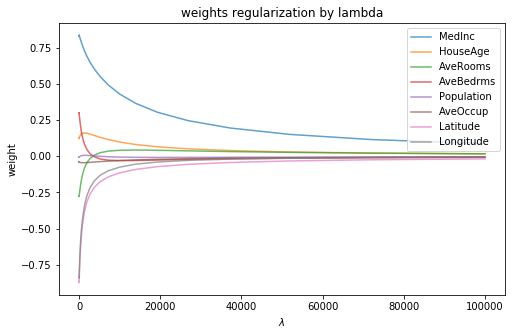

In [41]:
# plot weights with lambda regularization
weights_name = df.columns.values[:-1]
weights = weights[:, 1:] # remove bias term
plot_lambda_weights_effect(weights, lambda_vec, weights_name)

In [42]:
# find lambda has lowest difference between train and valid rmse
opt_lambda = lambda_vec[np.argmin(np.abs(train_rmse[1:] - valid_rmse[1:])) + 1]
data3_train_X_tr = preprocess_pipe.transform(data3_train_X)
model.alpha = opt_lambda

with tf.Session() as sess:
    model.fit(data3_train_X_tr, data3_train_y, sess)

print("optimal lambda {:2.6e}".format(opt_lambda))
show_model_result(model, preprocess_pipe, data3_train_set, data3_valid_set, data3_test_set)

optimal lambda 5.179475e+01
Train RMSE: 7.279158e-01
Valid RMSE: 7.278376e-01
Test RMSE: 7.191418e-01
weights:
 [2.063537e+00 8.296180e-01 1.280929e-01 -2.645710e-01 2.820357e-01
 -5.531576e-03 -4.087099e-02 -8.218333e-01 -7.887994e-01]


## Fit the training data using regression model with lasso (L1 penalty) regularization using TensorFlow.

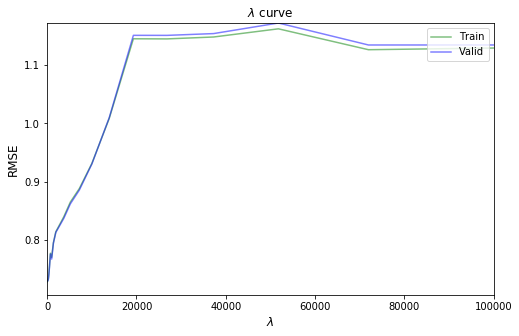

In [43]:
degree = 1

grid = np.linspace(-2, 5, 50)
lambda_vec = np.array([0] + [np.power(10.0, p) for p in grid])
#lambda_vec = np.r_[0, np.logspace(-2, 5, 20)].reshape(-1, 1)

train_rmse = np.zeros(len(lambda_vec))
valid_rmse = np.zeros(len(lambda_vec))

preprocess_pipe = create_poly_feature_pipe(degree, normalize=True)
data3_train_X_tr = preprocess_pipe.fit_transform(data3_train_X)
data3_valid_X_tr = preprocess_pipe.transform(data3_valid_X)

with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)

    weights = []
    for idx, lambda_ in enumerate(lambda_vec):

        model = TFGradientDescentSolver(lambda_, regularizer='Lasso', max_iter=3000)
        model.fit(data3_train_X_tr, data3_train_y, sess)
        weights.append(extract_model_weights(model))
    
        train_rmse[idx] = compute_rmse(data3_train_y, model.predict(data3_train_X_tr))
        valid_rmse[idx] = compute_rmse(data3_valid_y, model.predict(data3_valid_X_tr))

weights = np.squeeze(np.array(weights))    
    
plot_validate_curve(train_rmse, valid_rmse, lambda_vec)

#### TensorFlow Gradient Descent with lasso (L1 penalty) regularization $\lambda$ on weights effect

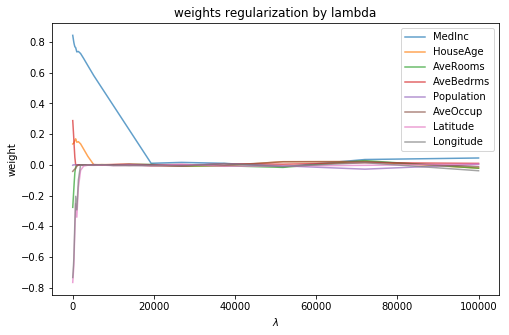

In [44]:
# plot weights with lambda regularization
weights_name = df.columns.values[:-1]
weights = weights[:, 1:] # remove bias term
plot_lambda_weights_effect(weights, lambda_vec, weights_name)

In [45]:
# find lambda has lowest difference between train and valid rmse
opt_lambda = lambda_vec[np.argmin(np.abs(train_rmse[1:] - valid_rmse[1:])) + 1]
data3_train_X_tr = preprocess_pipe.transform(data3_train_X)
model.alpha = opt_lambda

with tf.Session() as sess:
    model.fit(data3_train_X_tr, data3_train_y, sess)

print("optimal lambda {:2.6e}".format(opt_lambda))
show_model_result(model, preprocess_pipe, data3_train_set, data3_valid_set, data3_test_set)

optimal lambda 1.000000e+02
Train RMSE: 7.301747e-01
Valid RMSE: 7.301177e-01
Test RMSE: 7.218729e-01
weights:
 [2.063527e+00 8.265830e-01 1.382259e-01 -2.328131e-01 2.440240e-01
 -3.679899e-05 -3.909808e-02 -7.254146e-01 -6.908859e-01]
